In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import RobertaModel, AdamW
from transformers import RobertaTokenizer
import torch.optim as optim
from transformers import RobertaTokenizer
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
import numpy as np

2023-10-14 03:27:20.007352: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class BertAtt(nn.Module):
    def __init__(self, d_e, h):
        super(BertAtt, self).__init__()
        self.num_heads = h
        self.d_e = d_e
        self.head_dim = d_e // h
        
        self.q = nn.Linear(d_e, d_e)
        self.k = nn.Linear(d_e, d_e)
        self.v = nn.Linear(d_e, d_e)
        
        self.o = nn.Linear(d_e, d_e)
        self.layer_norm = nn.LayerNorm(d_e)
        
        self.dropout = nn.Dropout(dropout_prob)
        
    def forward(self, x):
        Q = self.q(x)
        K = self.k(x)
        V = self.v(x)
        
        Q = Q.view(Q.size(0), -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(K.size(0), -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(V.size(0), -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        
        
        attention_scores = torch.matmul(Q, K.permute(0, 1, 3, 2)) / (self.d_e**0.5)
        attention_probs = F.softmax(attention_scores, dim=-1)
        context = torch.matmul(attention_probs, V)
        
        context = context.permute(0, 2, 1, 3).contiguous()
        context = context.view(context.size(0), -1, self.num_heads*self.head_dim)
        context = self.dropout(context)
        context = self.o(context)
        
        return self.layer_norm(x + context)

class HBN(nn.Module):
    def __init__(self, d_e, h, m, n, y, dropout_prob=0.01, max_sentences=114):
        super(HBN, self).__init__()
        
        # Token-level Roberta encoder
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        
        # Freeze Roberta weights
        for param in self.roberta.parameters():
            param.requires_grad = False
        
        # Sentence-level BERT Encoder
        self.bertatt = BertAtt(d_e, h)
        
        self.ff = nn.Sequential(
            nn.Linear(d_e, n*d_e),
            nn.ReLU(),
            nn.Linear(n*d_e, d_e)
        )
        self.layer_norm = nn.LayerNorm(d_e)
        
        self.multiple_bert_layers = nn.ModuleList([BertAtt(d_e, h) for _ in range(m)])
        
        self.transformation = nn.Linear(d_e, d_e)
        
        self.dropout = nn.Dropout(dropout_prob)
        
        # Prediction Layer
        self.predict = nn.Linear(d_e, y)
        
    def forward(self, input_ids, attention_mask):
#         print(input_ids.shape)
        # Token-level Roberta encoding
        roberta_outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)[0]  # [batch_size, seq_length, hidden_size]
        
        # Average pooling to get sentence embeddings
        D = torch.mean(roberta_outputs, dim=1)  # [batch_size, hidden_size]
        
        out = self.bertatt(D)
        out = self.layer_norm(out + F.relu(self.ff(out)))
        
        Z = out
        for layer in self.multiple_bert_layers:
            Z = layer(Z)
        
        S = torch.tanh(torch.mean(Z, dim=1).mm(self.transformation.weight))
        S = self.dropout(S)
        scores = S.mm(self.predict.weight.t())
        
        return scores


In [6]:
# Parameters
d_e = 768  # Assuming you are using 'roberta-base'
h = 1     # Number of attention heads
m = 4      # Number of identical BERT layers
n = 4      # Scaling factor for feed-forward network
y = 2      # Number of classes, set this to your actual number
dropout_prob = 0.01 #dropout probability
num_train_samples = 150
num_epochs = 50
max_length = 128

In [12]:
# 1. Load and shuffle the data
train = pd.read_excel('/Vol1/sushant/Script/DLNLP/Assignment 1/ClassificationDataset-train1.xlsx')
train_combined = pd.DataFrame(columns=['Review', 'Label'])
train_combined['Review'] = pd.concat([train['Negative Review'], train['Positive Review']], ignore_index=True)
num_negative_reviews = len(train['Negative Review'])
train_combined['Label'] = [0] * num_negative_reviews + [1] * (len(train_combined) - num_negative_reviews)
df = train_combined.sample(frac=1, random_state=42).reset_index(drop=True)
positive_samples = df[df['Label'] == 1].sample(1000)
negative_samples = df[df['Label'] == 0].sample(1000)

data = pd.concat([positive_samples, negative_samples])
data = data.sample(frac=1).reset_index(drop=True)


# reviews = data['Review'].tolist()
# labels = data['Label'].tolist()

# # 2. Preprocess
# reviews = [review.lower() for review in reviews]
# reviews_sentences = [sent_tokenize(review) for review in reviews]
# flattened_reviews = [sentence for review in reviews_sentences for sentence in review]
# flattened_labels = [label for review, label in zip(reviews_sentences, labels) for sentence in review]

# # 3. Tokenization
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# flattened_tokens = tokenizer(flattened_reviews, padding=True, truncation=True, return_tensors="pt", max_length=114)

# # 4. Split data into train, validation, and test samples
# num_val_samples = int(0.2 * num_train_samples)
# train_indices = torch.randperm(len(flattened_reviews))[:num_train_samples]
# val_indices = torch.randperm(len(flattened_reviews))[:num_val_samples]
# test_indices = torch.tensor([idx for idx in range(len(flattened_reviews)) if idx not in np.concatenate([train_indices.numpy(), val_indices.numpy()])])

# train_input_ids = flattened_tokens['input_ids'][train_indices]
# train_attention_mask = flattened_tokens['attention_mask'][train_indices]
# train_labels = torch.tensor([flattened_labels[idx] for idx in train_indices])

# val_input_ids = flattened_tokens['input_ids'][val_indices]
# val_attention_mask = flattened_tokens['attention_mask'][val_indices]
# val_labels = torch.tensor([flattened_labels[idx] for idx in val_indices])

# test_input_ids = flattened_tokens['input_ids'][test_indices]
# test_attention_mask = flattened_tokens['attention_mask'][test_indices]
# test_labels = torch.tensor([flattened_labels[idx] for idx in test_indices])

# # 5. Create DataLoader
# train_batch_size = 4
# val_batch_size = 4
# test_batch_size = 4

# train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)
# train_loader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)

# val_dataset = TensorDataset(val_input_ids, val_attention_mask, val_labels)
# val_loader = DataLoader(val_dataset, shuffle=False, batch_size=val_batch_size)

# test_dataset = TensorDataset(test_input_ids, test_attention_mask, test_labels)
# test_loader = DataLoader(test_dataset, shuffle=False, batch_size=test_batch_size)

# # # Uncomment to test: iterating over the DataLoader
# # for batch in train_loader:
# #     input_ids, attention_mask, labels = batch
# #     print(input_ids.shape, attention_mask.shape, labels.shape)

# # for batch in val_loader:
# #     input_ids, attention_mask, labels = batch
# #     print(input_ids.shape, attention_mask.shape, labels.shape)

# # for batch in test_loader:
# #     input_ids, attention_mask, labels = batch
# #     print(input_ids.shape, attention_mask.shape, labels.shape)


In [13]:
# 2. Split data into train, validation, and test samples
num_train_samples = num_train_samples
num_val_samples = int(0.2 * num_train_samples)
train_data = data.iloc[:num_train_samples]
val_data = data.iloc[num_train_samples:num_train_samples+num_val_samples]
test_data = data.iloc[num_train_samples+num_val_samples:]

# 3. Preprocess and Flatten
def preprocess_and_flatten(dataframe):
    reviews = dataframe['Review'].tolist()
    labels = dataframe['Label'].tolist()
    reviews = [review.lower() for review in reviews]
    reviews_sentences = [sent_tokenize(review) for review in reviews]
    flattened_reviews = [sentence for review in reviews_sentences for sentence in review]
    flattened_labels = [label for review, label in zip(reviews_sentences, labels) for sentence in review]
    return flattened_reviews, flattened_labels

train_reviews, train_labels = preprocess_and_flatten(train_data)
val_reviews, val_labels = preprocess_and_flatten(val_data)
test_reviews, test_labels = preprocess_and_flatten(test_data)

# 4. Tokenization
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_tokens = tokenizer(train_reviews, padding=True, truncation=True, return_tensors="pt", max_length=max_length)
val_tokens = tokenizer(val_reviews, padding=True, truncation=True, return_tensors="pt", max_length=max_length)
test_tokens = tokenizer(test_reviews, padding=True, truncation=True, return_tensors="pt", max_length=max_length)

# 5. Create DataLoader
train_batch_size = 4
val_batch_size = 4
test_batch_size = 4

train_dataset = TensorDataset(train_tokens['input_ids'], train_tokens['attention_mask'], torch.tensor(train_labels))
val_dataset = TensorDataset(val_tokens['input_ids'], val_tokens['attention_mask'], torch.tensor(val_labels))
test_dataset = TensorDataset(test_tokens['input_ids'], test_tokens['attention_mask'], torch.tensor(test_labels))

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=val_batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=test_batch_size)

# Uncomment to test: iterating over the DataLoader
for batch in train_loader:
    input_ids, attention_mask, labels = batch
    print(input_ids.shape, attention_mask.shape, labels.shape)
len(train_loader.dataset),len(val_loader.dataset),len(test_loader.dataset)

torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4,

(150, 30, 1818)

In [14]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = HBN(d_e, h, m, n, y, dropout_prob).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
def train(model, dataloader, optimizer, criterion, device, epoch):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        input_ids, attention_mask, labels = batch
        
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids, attention_mask, labels = batch

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels)
            
            # For AUC
            # Assuming binary classification; you need to get the probabilities for the positive class
            probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct_predictions.double() / len(dataloader.dataset)
    auc = roc_auc_score(all_labels, all_preds)
    return total_loss / len(dataloader), accuracy, auc



In [16]:
# Actual Training Loop
num_epochs = 50
train_loss_epoch = []
test_loss_epoch = []
auc = []
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device, epoch)
    print(f"Train Loss: {train_loss:.4f}")
    val_loss, val_accuracy, val_auc = evaluate(model, val_loader, criterion, device)
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val AUC: {val_auc:.4f}")
    train_loss_epoch.append(train_loss)
    test_loss_epoch.append(val_loss)
    auc.append(val_auc)

Epoch 1/50: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:13<00:00,  2.82it/s]


Train Loss: 0.7133


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.14it/s]


Val Loss: 0.6923, Val Accuracy: 0.6333, Val AUC: 0.6968


Epoch 2/50: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:12<00:00,  2.96it/s]


Train Loss: 0.7237


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.82it/s]


Val Loss: 0.7655, Val Accuracy: 0.4333, Val AUC: 0.8009


Epoch 3/50: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:12<00:00,  3.11it/s]


Train Loss: 0.6654


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


Val Loss: 0.6592, Val Accuracy: 0.6333, Val AUC: 0.7240


Epoch 4/50: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:10<00:00,  3.78it/s]


Train Loss: 0.5887


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


Val Loss: 0.6271, Val Accuracy: 0.7333, Val AUC: 0.7919


Epoch 5/50: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:11<00:00,  3.43it/s]


Train Loss: 0.5171


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.50it/s]


Val Loss: 0.7318, Val Accuracy: 0.7000, Val AUC: 0.8145


Epoch 6/50: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:09<00:00,  3.83it/s]


Train Loss: 0.4976


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.85it/s]


Val Loss: 0.6770, Val Accuracy: 0.7667, Val AUC: 0.8326


Epoch 7/50: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:11<00:00,  3.35it/s]


Train Loss: 0.3632


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.76it/s]


Val Loss: 0.6767, Val Accuracy: 0.8667, Val AUC: 0.8281


Epoch 8/50: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:11<00:00,  3.39it/s]


Train Loss: 0.3857


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.78it/s]


Val Loss: 0.6464, Val Accuracy: 0.8333, Val AUC: 0.8281


Epoch 9/50: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:10<00:00,  3.76it/s]


Train Loss: 0.3402


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.35it/s]


Val Loss: 0.6233, Val Accuracy: 0.8000, Val AUC: 0.8326


Epoch 10/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:12<00:00,  3.15it/s]


Train Loss: 0.3060


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.38it/s]


Val Loss: 0.7868, Val Accuracy: 0.8000, Val AUC: 0.8326


Epoch 11/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:11<00:00,  3.45it/s]


Train Loss: 0.3097


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.66it/s]


Val Loss: 0.6907, Val Accuracy: 0.8000, Val AUC: 0.8597


Epoch 12/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:10<00:00,  3.67it/s]


Train Loss: 0.2663


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.76it/s]


Val Loss: 0.7042, Val Accuracy: 0.8000, Val AUC: 0.8778


Epoch 13/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:10<00:00,  3.54it/s]


Train Loss: 0.2588


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.80it/s]


Val Loss: 0.7055, Val Accuracy: 0.8000, Val AUC: 0.8733


Epoch 14/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:10<00:00,  3.55it/s]


Train Loss: 0.2066


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.17it/s]


Val Loss: 0.5565, Val Accuracy: 0.8667, Val AUC: 0.8869


Epoch 15/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:10<00:00,  3.72it/s]


Train Loss: 0.1619


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.81it/s]


Val Loss: 0.5198, Val Accuracy: 0.8333, Val AUC: 0.9005


Epoch 16/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:09<00:00,  3.88it/s]


Train Loss: 0.1890


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.57it/s]


Val Loss: 0.5106, Val Accuracy: 0.8333, Val AUC: 0.9231


Epoch 17/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:10<00:00,  3.48it/s]


Train Loss: 0.2041


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.64it/s]


Val Loss: 0.9186, Val Accuracy: 0.7667, Val AUC: 0.9095


Epoch 18/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:09<00:00,  3.82it/s]


Train Loss: 0.2016


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.74it/s]


Val Loss: 0.5829, Val Accuracy: 0.8000, Val AUC: 0.9231


Epoch 19/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:09<00:00,  4.01it/s]


Train Loss: 0.1874


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.38it/s]


Val Loss: 0.5733, Val Accuracy: 0.8333, Val AUC: 0.9186


Epoch 20/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:07<00:00,  5.29it/s]


Train Loss: 0.2322


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.35it/s]


Val Loss: 0.5529, Val Accuracy: 0.8333, Val AUC: 0.8914


Epoch 21/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:07<00:00,  5.12it/s]


Train Loss: 0.1688


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.36it/s]


Val Loss: 0.7155, Val Accuracy: 0.8000, Val AUC: 0.9186


Epoch 22/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.46it/s]


Train Loss: 0.0835


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.49it/s]


Val Loss: 0.4311, Val Accuracy: 0.9333, Val AUC: 0.9276


Epoch 23/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.87it/s]


Train Loss: 0.1655


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.49it/s]


Val Loss: 0.4511, Val Accuracy: 0.9000, Val AUC: 0.9276


Epoch 24/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.78it/s]


Train Loss: 0.0943


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.48it/s]


Val Loss: 0.7267, Val Accuracy: 0.8000, Val AUC: 0.9095


Epoch 25/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.83it/s]


Train Loss: 0.1530


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.39it/s]


Val Loss: 0.4402, Val Accuracy: 0.9000, Val AUC: 0.9231


Epoch 26/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.70it/s]


Train Loss: 0.1324


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.48it/s]


Val Loss: 0.4819, Val Accuracy: 0.9000, Val AUC: 0.9231


Epoch 27/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.91it/s]


Train Loss: 0.0712


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.45it/s]


Val Loss: 0.3867, Val Accuracy: 0.9333, Val AUC: 0.9321


Epoch 28/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.95it/s]


Train Loss: 0.0842


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.50it/s]


Val Loss: 0.7362, Val Accuracy: 0.8000, Val AUC: 0.9276


Epoch 29/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.96it/s]


Train Loss: 0.0836


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.47it/s]


Val Loss: 0.5627, Val Accuracy: 0.8333, Val AUC: 0.9321


Epoch 30/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.95it/s]


Train Loss: 0.1277


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.46it/s]


Val Loss: 0.4473, Val Accuracy: 0.9333, Val AUC: 0.9231


Epoch 31/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.84it/s]


Train Loss: 0.1037


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.50it/s]


Val Loss: 0.5929, Val Accuracy: 0.8333, Val AUC: 0.9231


Epoch 32/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.97it/s]


Train Loss: 0.0939


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.48it/s]


Val Loss: 0.4145, Val Accuracy: 0.9000, Val AUC: 0.9276


Epoch 33/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.96it/s]


Train Loss: 0.1172


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.51it/s]


Val Loss: 0.4345, Val Accuracy: 0.9000, Val AUC: 0.9321


Epoch 34/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.97it/s]


Train Loss: 0.0331


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.44it/s]


Val Loss: 0.3778, Val Accuracy: 0.9333, Val AUC: 0.9321


Epoch 35/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.97it/s]


Train Loss: 0.0456


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.53it/s]


Val Loss: 0.6937, Val Accuracy: 0.9000, Val AUC: 0.9321


Epoch 36/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.95it/s]


Train Loss: 0.1092


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.45it/s]


Val Loss: 0.6462, Val Accuracy: 0.9000, Val AUC: 0.9095


Epoch 37/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.94it/s]


Train Loss: 0.1007


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.22it/s]


Val Loss: 0.5862, Val Accuracy: 0.9000, Val AUC: 0.9276


Epoch 38/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.93it/s]


Train Loss: 0.1297


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.04it/s]


Val Loss: 0.5048, Val Accuracy: 0.9000, Val AUC: 0.9276


Epoch 39/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.95it/s]


Train Loss: 0.0679


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.49it/s]


Val Loss: 0.7246, Val Accuracy: 0.8000, Val AUC: 0.9276


Epoch 40/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.96it/s]


Train Loss: 0.0726


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.51it/s]


Val Loss: 0.3459, Val Accuracy: 0.9333, Val AUC: 0.9321


Epoch 41/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.95it/s]


Train Loss: 0.0762


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.45it/s]


Val Loss: 0.3623, Val Accuracy: 0.9333, Val AUC: 0.9321


Epoch 42/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.86it/s]


Train Loss: 0.0413


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.44it/s]


Val Loss: 0.3457, Val Accuracy: 0.9667, Val AUC: 0.9321


Epoch 43/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.96it/s]


Train Loss: 0.0793


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.48it/s]


Val Loss: 0.3593, Val Accuracy: 0.9333, Val AUC: 0.9321


Epoch 44/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.96it/s]


Train Loss: 0.0714


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.50it/s]


Val Loss: 0.3271, Val Accuracy: 0.9667, Val AUC: 0.9321


Epoch 45/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.95it/s]


Train Loss: 0.0915


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.44it/s]


Val Loss: 0.5216, Val Accuracy: 0.9000, Val AUC: 0.9321


Epoch 46/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.96it/s]


Train Loss: 0.0592


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.51it/s]


Val Loss: 0.4365, Val Accuracy: 0.9000, Val AUC: 0.9321


Epoch 47/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.93it/s]


Train Loss: 0.0506


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.50it/s]


Val Loss: 0.4537, Val Accuracy: 0.9000, Val AUC: 0.9276


Epoch 48/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.86it/s]


Train Loss: 0.0680


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.49it/s]


Val Loss: 0.5190, Val Accuracy: 0.9000, Val AUC: 0.9321


Epoch 49/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.96it/s]


Train Loss: 0.0599


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.50it/s]


Val Loss: 0.3602, Val Accuracy: 0.9667, Val AUC: 0.9321


Epoch 50/50: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.95it/s]


Train Loss: 0.0751


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.45it/s]

Val Loss: 0.4973, Val Accuracy: 0.9000, Val AUC: 0.9321


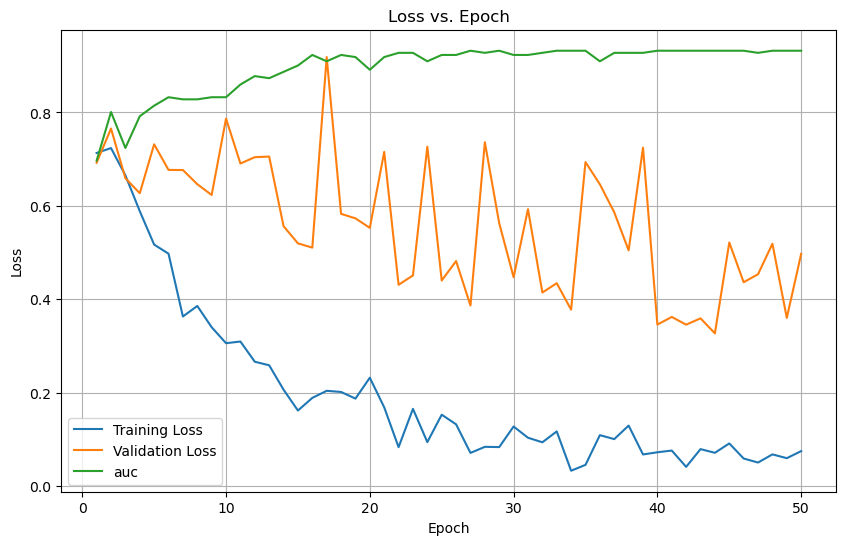

In [17]:
import matplotlib.pyplot as plt

# Plot Loss vs. Epoch
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_epoch, label='Training Loss')
plt.plot(epochs, test_loss_epoch, label='Validation Loss')
plt.plot(epochs, auc, label='auc')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
val_loss, val_accuracy, val_auc = evaluate(model, test_loader, criterion, device)
print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val AUC: {val_auc:.4f}")

100%|█████████████████████████████████████████████████████████████████████████████████| 455/455 [00:58<00:00,  7.82it/s]

Val Loss: 0.4455, Val Accuracy: 0.8867, Val AUC: 0.9477
